In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from astropy import units as u
from astropy import constants as const
from scipy.optimize import curve_fit
from Class_func import Cube

#set the default plot parameter
plt_param={'font.family':'serif',
           'font.serif':'Times New Roman',
           'lines.linewidth':1,
           'xtick.labelsize':12,
           'ytick.labelsize':12,
           'axes.labelsize':16,
           'xtick.direction':'in',
           'ytick.direction':'in',
           'font.style':'italic',
           'font.weight':'normal',
           'figure.figsize':[5,5],'xtick.minor.visible':True,
           'ytick.minor.visible':True,
           'xtick.major.size':4,
           'ytick.major.size':4,
           'xtick.minor.size':2,
           'ytick.minor.size':2,
           'xtick.major.width':.8,
           'ytick.major.width':.8,
           'xtick.top':True,
           'ytick.right':True,
           'axes.spines.bottom':True,
           'axes.spines.top':True,
           'axes.spines.left':True,
           'axes.spines.right':True,
           'xtick.bottom':True,
           'xtick.labelbottom':True,
           'ytick.left':True,
           'ytick.labelleft':True}
rcParams.update(plt_param)

In [2]:
dic='/Users/shiwuzhang/WS/ASTRO/MAMMOTH_KCWI/'
ss_name='1441+4003_comb_ss_icubes.fits'
psf_name='1441+4003_comb_psfs_icubes.fits'
refpoint=np.array([220.3520886,40.05269183])*u.deg+np.array([-1,0])*u.arcsec
sscube=Cube.read(dic+ss_name,refpoint=refpoint)
psfcube=Cube.read(dic+psf_name,refpoint=refpoint)

In [3]:
lycube=sscube.subcube(zhi=4080*u.AA,zlo=3990*u.AA,refpoint=refpoint)
heiicube=psfcube.subcube(zhi=5440*u.AA,zlo=5520*u.AA,refpoint=refpoint)
heiicube2=psfcube.subcube(zhi=5470*u.AA,zlo=5490*u.AA,refpoint=refpoint)
civcube=psfcube.subcube(zhi=5250*u.AA,zlo=5150*u.AA,refpoint=refpoint)

In [4]:
def spectralextract(cube,aper_radius):
    '''
    extract spectral at location of 
    central sources within aper_radius
    '''
    delta_x=cube.dec.to(u.arcsec).value
    delta_y=cube.ra.to(u.arcsec).value
    X,Y=np.meshgrid(delta_x,delta_y)
    rmap=np.sqrt((X**2)+(Y**2))
    boolmap=(rmap<=aper_radius)
    spectrum=cube.hdu.data[:,boolmap].mean(axis=1)
    
    return spectrum*1e3,cube.spectral_axis.to(u.AA).value

def gaussian(x,mu,sigma,A):
    
    exp_index=-0.5*np.power((x-mu)/sigma,2)
    y=A*np.exp(exp_index)
    return y

def emissionfit(fitfunc,x,y,initpara=None):
    popt,pcov=curve_fit(fitfunc,x,y,p0=initpara,
                        method='lm',maxfev=100000)
    return popt,pcov

In [5]:
lyspec,ly_axis=spectralextract(lycube,2)
heiispec,heii_axis=spectralextract(heiicube,2)
heiispec2,heii_axis2=spectralextract(heiicube2,2)
civspec,civ_axis=spectralextract(civcube,2)

lypara,_=emissionfit(gaussian,ly_axis,lyspec,[4025.,25.,25.])
heiipara,_=emissionfit(gaussian,heii_axis2,heiispec2,[5475.,10.,4.])
civpara,_=emissionfit(gaussian,civ_axis,civspec,[5185.,30.,2.])

ly_axis_model=np.linspace(np.min(ly_axis),np.max(ly_axis),500)
lyspec_model=gaussian(ly_axis_model,*lypara)
heii_axis_model=np.linspace(np.min(heii_axis),np.max(heii_axis),500)
heiispec_model=gaussian(heii_axis_model,*heiipara)+9.5e-5*heii_axis_model
civ_axis_model=np.linspace(np.min(civ_axis),np.max(civ_axis),500)
civspec_model=gaussian(civ_axis_model,*civpara)

In [6]:
spec=[lyspec,heiispec,civspec]
spec_axis=[ly_axis,heii_axis-40,civ_axis-40]
spec_model=[lyspec_model,heiispec_model,civspec_model]
spec_axis_model=[ly_axis_model,heii_axis_model-40,civ_axis_model-40]

In [7]:
lypara_text=lypara.astype(np.int32)
heiipara_text=heiipara.astype(np.int32)
civpara_text=civpara.astype(np.int32)
paramlist=np.array([lypara_text,heiipara_text+np.array([-40,0,0]),
                    civpara_text+np.array([-40,0,0])])
text=[]
for i in range(3):
    st='$\lambda$: %d $\AA$\n$\sigma$: %d $\AA$\nA: %d'%(paramlist[i,0],paramlist[i,1],paramlist[i,2])
    text.append(st)

In [8]:
lyspec_axis_v=lycube.with_spectral_unit(u.km/u.s,velocity_convention='relativistic',
                                        rest_value=3.312*1215.673*u.AA).spectral_axis.value.astype(np.int32)
heiispec_axis_v=heiicube.with_spectral_unit(u.km/u.s,velocity_convention='relativistic',
                                            rest_value=3.34*1640*u.AA).spectral_axis.value.astype(np.int32)
civspec_axis_v=civcube.with_spectral_unit(u.km/u.s,velocity_convention='relativistic',
                                          rest_value=3.34589*1549*u.AA).spectral_axis.value.astype(np.int32)

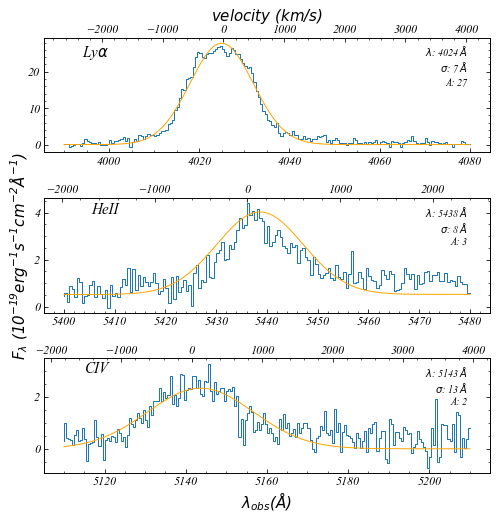

In [13]:
title=[r'Ly$\alpha$','HeII','CIV']
additional_spec_axis=[lyspec_axis_v,heiispec_axis_v,civspec_axis_v]
dic='/Users/shiwuzhang/WS/ASTRO/MAMMOTH_KCWI/draft_code/paper/ApJtemplate/figs/'
fig,AX=plt.subplots(3,1)
AX=AX.flatten()
for i in range(3):
    AX[i].step(spec_axis[i],spec[i])
    AX[i].plot(spec_axis_model[i],spec_model[i],color='orange')
    AX[i].text(spec_axis[i].min()*1.001,spec[i].max()*.9,title[i],fontsize=15.)
    ax=AX[i].twiny()
    ax.plot(additional_spec_axis[i],
            np.zeros_like(additional_spec_axis[i]),
            color='white',alpha=.001)
    AX[i].annotate(text[i], xy=(0.95,.95),xycoords='axes fraction',fontsize=10,
                   horizontalalignment='right', verticalalignment='top')
    if i==0:
        ax.set_xlabel(r'$\rm velocity \ (km/s)$',fontsize=15)
AX[2].set_xlabel(r'$\lambda_{obs}(\AA)$',fontsize=15)
AX[1].set_ylabel(r'$F_{\lambda} \ (10^{-19} erg^{-1}s^{-1}cm^{-2}\AA^{-1})$',fontsize=15)
plt.subplots_adjust(hspace=.4)
plt.rcParams['figure.figsize'] = [8, 8]
plt.savefig(dic+'spectral.png',dpi=300)
plt.show()